# Face Generation

In this project, a Deep Convolutional Generative Adversarial Network (DCGAN) is defined and trained on a dataset of faces. The goal is to get a generator network to generate new images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is used to train the adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) and needs deeper networks and training the networks for a longer time to get good results. It is suggested that a GPU be utilized for training.

### Pre-processed Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is shown below.

<img src='assets/processed_face_data.png' width=60% />

> If working locally, this data can be downloaded [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This zip file needs to be extracted from the home directory of this notebook for further loading and processing. After extracting the data, the directory of data should be `processed_celeba_small/`

In [4]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [5]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [6]:
# necessary imports
import os
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


In [7]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # define transform
    transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor()])
    
    # get training data directory
    celeba_path = './' + data_dir 
    #train_path = os.path.join(train_path, 'celeba')
    
    # define ImageFolder
    celeba_dataset = datasets.ImageFolder(celeba_path, transform)
    
    # define and return dataloader
    celeba_dataloader = DataLoader(celeba_dataset, batch_size = batch_size, shuffle = True)
    
    return celeba_dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [8]:
# Define function hyperparameters
batch_size = 16
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

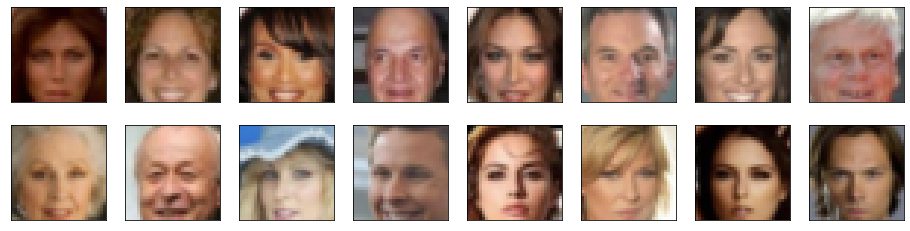

In [9]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(16, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [10]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = (max - min)*x + min
    
    return x


In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.3961)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [14]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim, batch_s):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        # convolutional layer 1 - (input: 32x32x3; output: 16x16x32)
        self.conv1 = conv(3, conv_dim, kernel_size = 4, batch_norm=False)
        # convolutional layer 2 - (input: 16x16x32; output: 8x8x64)
        self.conv2 = conv(conv_dim, conv_dim*2, kernel_size = 4)
        # convolutional layer 3 - (input: 8x8x64; output: 4x4x128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size = 4)
        # convolutional layer 4 - (input: 4x4x128; output: 2x2x256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, kernel_size = 4)
        # convolutional layer 5 - (input: 2x2x256; output: 1x1x512)
        self.conv5 = conv(conv_dim*8, conv_dim*16, kernel_size = 4)

        # linear layer (1x1x512 -> 1)
        self.fc1 = nn.Linear(1*1*conv_dim*batch_s, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # 1st conv layer
        x = F.leaky_relu(self.conv1(x), 0.2)  # (input, negative_slope = 0.2)
        # 2nd conv layer
        x = F.leaky_relu(self.conv2(x), 0.2)
        # 3rd conv layer
        x = F.leaky_relu(self.conv3(x), 0.2)
        # 4th conv layer
        x = F.leaky_relu(self.conv4(x), 0.2)
        # 5th conv layer
        x = F.leaky_relu(self.conv5(x), 0.2)
        
        # define batch size first
        # batch_size = x.shape[0]
        
        # flatten image input - conv5 output 
        x = x.view(-1, 1*1*conv_dim*16)
        
        
        # final layer
        x = self.fc1(x)
        
        return x


# """
# DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
# """
#tests.test_discriminator(Discriminator)

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [15]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    # apply deconv layer
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    # append deconv layer
    layers.append(deconv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    # using Sequential container
    return nn.Sequential(*layers)

In [16]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim, batch_s):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        # linear layer (input noise, z_size -> 1*1*512)
        self.fc1 = nn.Linear(z_size, 1*1*conv_dim*batch_s)
        
        # deconvolutional layer 1 - (input: 1*1*512; output: 2*2*256)
        self.transconv1 = deconv(conv_dim*16, conv_dim*8, kernel_size = 4)
        # deconvolutional layer 2 - (input: 2x2x256; output: 4x4x128)
        self.transconv2 = deconv(conv_dim*8, conv_dim*4, kernel_size = 4)
        # deconvolutional layer 3 - (input: 4x4x128; output: 8x8x64)
        self.transconv3 = deconv(conv_dim*4, conv_dim*2, kernel_size = 4)
        # deconvolutional layer 4 - (input: 8x8x64; output: 16x16x32)
        self.transconv4 = deconv(conv_dim*2, conv_dim, kernel_size = 4)
        # deconvolutional layer 5 - (input: 16x16x32; output: 32x32x3)
        self.transconv5 = deconv(conv_dim, 3, kernel_size = 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        # 1st fc layer
        x = self.fc1(x)
        
        # reshape x - fc layer output
        # define batch size first
        batch_size = x.shape[0]
        # reshape tensor
        x = x.view(batch_size, conv_dim*16, 1, 1)
        
        # 1st deconv layer
        x = F.relu(self.transconv1(x), 0.2)  # (input, negative_slope = 0.2)
        # 2nd deconv layer
        x = F.relu(self.transconv2(x), 0.2)
        # 3rd deconv layer
        x = F.relu(self.transconv3(x), 0.2)
        # 4th deconv layer
        x = F.relu(self.transconv4(x), 0.2)
        # 5th deconv layer
        x = self.transconv5(x)
        
        # apply tanh to output of deconv4 
        x = torch.tanh(x)
        
        return x

# """
# DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
# """
# # tests.test_generator(Generator)

## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [17]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        m.weight.data.normal_(0, 0.02)
        # m.bias.data.fill_(0)        
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size, batch_s):
    # define discriminator and generator
    D = Discriminator(conv_dim=d_conv_dim, batch_s=batch_s)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim, batch_s=batch_s)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [19]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100
batch_s= 16
conv_dim = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size, batch_s)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=512, out_features=1, bia

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [21]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    # define batch_size
    batch_size = D_out.size(0)
    # define labels with label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    # move labels to gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    labels = labels.to(device)
    # claculate loss
    # least square error loss
    # loss = torch.mean((D_out.squeeze() - labels)**2)
    # binary cross entropy with logit loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    # define batch_size
    batch_size = D_out.size(0)
    # define labels    
    labels = torch.zeros(batch_size)
    # move labels to gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    labels = labels.to(device)
    # claculate loss
    #loss = torch.mean((D_out.squeeze() - labels)**2)
    # binary cross entropy with logit loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [22]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [24]:
from tqdm import tqdm

def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move fixed_z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in tqdm(enumerate(celeba_train_loader)):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
        
            #  Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()


            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
        
            # Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            # apply generator to noise, z
            fake_images = G(z)

            # generator losses:
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [26]:
# set number of epochs 
n_epochs = 5


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

1it [00:00,  3.03it/s]

Epoch [    1/    5] | d_loss: 1.3981 | g_loss: 0.7100


51it [00:22,  2.46it/s]

Epoch [    1/    5] | d_loss: 1.3442 | g_loss: 0.7303


101it [00:43,  1.96it/s]

Epoch [    1/    5] | d_loss: 1.2861 | g_loss: 0.7698


151it [01:08,  1.71it/s]

Epoch [    1/    5] | d_loss: 1.1546 | g_loss: 0.8748


201it [01:40,  1.79it/s]

Epoch [    1/    5] | d_loss: 0.9750 | g_loss: 0.9067


251it [02:06,  2.21it/s]

Epoch [    1/    5] | d_loss: 1.0532 | g_loss: 0.9947


301it [02:31,  2.12it/s]

Epoch [    1/    5] | d_loss: 0.9255 | g_loss: 1.0128


351it [02:55,  1.92it/s]

Epoch [    1/    5] | d_loss: 0.6641 | g_loss: 1.1836


401it [03:19,  2.13it/s]

Epoch [    1/    5] | d_loss: 1.1907 | g_loss: 0.9359


451it [03:41,  2.45it/s]

Epoch [    1/    5] | d_loss: 1.3510 | g_loss: 0.8223


501it [04:04,  2.46it/s]

Epoch [    1/    5] | d_loss: 1.3767 | g_loss: 0.8858


551it [04:27,  1.89it/s]

Epoch [    1/    5] | d_loss: 1.0647 | g_loss: 0.9690


601it [04:50,  2.25it/s]

Epoch [    1/    5] | d_loss: 1.1562 | g_loss: 0.8133


651it [05:14,  1.81it/s]

Epoch [    1/    5] | d_loss: 1.1192 | g_loss: 1.1448


701it [05:43,  2.17it/s]

Epoch [    1/    5] | d_loss: 1.5578 | g_loss: 1.0758


751it [06:08,  1.92it/s]

Epoch [    1/    5] | d_loss: 0.9876 | g_loss: 1.0303


801it [06:33,  1.72it/s]

Epoch [    1/    5] | d_loss: 1.2572 | g_loss: 1.0685


851it [06:58,  2.11it/s]

Epoch [    1/    5] | d_loss: 0.9084 | g_loss: 1.0018


901it [07:22,  2.35it/s]

Epoch [    1/    5] | d_loss: 0.9100 | g_loss: 1.3603


951it [07:46,  2.24it/s]

Epoch [    1/    5] | d_loss: 1.0236 | g_loss: 0.9111


1001it [08:11,  2.20it/s]

Epoch [    1/    5] | d_loss: 1.0335 | g_loss: 0.9163


1051it [08:34,  2.15it/s]

Epoch [    1/    5] | d_loss: 1.2008 | g_loss: 0.9582


1101it [08:57,  2.45it/s]

Epoch [    1/    5] | d_loss: 1.5972 | g_loss: 1.1636


1151it [09:17,  2.52it/s]

Epoch [    1/    5] | d_loss: 0.8500 | g_loss: 1.1108


1201it [09:38,  2.33it/s]

Epoch [    1/    5] | d_loss: 1.3410 | g_loss: 1.0493


1251it [10:00,  2.07it/s]

Epoch [    1/    5] | d_loss: 1.2037 | g_loss: 1.0662


1301it [10:21,  2.45it/s]

Epoch [    1/    5] | d_loss: 1.2778 | g_loss: 1.0993


1351it [10:42,  2.35it/s]

Epoch [    1/    5] | d_loss: 1.2627 | g_loss: 0.8710


1401it [11:04,  2.30it/s]

Epoch [    1/    5] | d_loss: 1.7266 | g_loss: 1.0706


1451it [11:26,  1.88it/s]

Epoch [    1/    5] | d_loss: 1.1148 | g_loss: 0.9002


1501it [11:49,  2.27it/s]

Epoch [    1/    5] | d_loss: 1.3612 | g_loss: 0.8101


1525it [11:59,  2.12it/s]
2it [00:00,  5.18it/s]

Epoch [    2/    5] | d_loss: 1.2567 | g_loss: 0.7409


51it [00:11,  4.75it/s]

Epoch [    2/    5] | d_loss: 1.4044 | g_loss: 0.9753


101it [00:21,  4.89it/s]

Epoch [    2/    5] | d_loss: 1.2053 | g_loss: 0.8100


151it [00:31,  4.83it/s]

Epoch [    2/    5] | d_loss: 1.3835 | g_loss: 0.7881


202it [00:42,  4.95it/s]

Epoch [    2/    5] | d_loss: 1.2674 | g_loss: 0.8342


252it [00:52,  4.83it/s]

Epoch [    2/    5] | d_loss: 1.2414 | g_loss: 0.9616


302it [01:03,  4.54it/s]

Epoch [    2/    5] | d_loss: 1.5458 | g_loss: 0.9220


351it [01:14,  4.37it/s]

Epoch [    2/    5] | d_loss: 1.1020 | g_loss: 0.8267


401it [01:26,  4.03it/s]

Epoch [    2/    5] | d_loss: 1.0882 | g_loss: 0.8732


451it [01:39,  3.02it/s]

Epoch [    2/    5] | d_loss: 1.3146 | g_loss: 0.9553


501it [01:51,  4.60it/s]

Epoch [    2/    5] | d_loss: 1.1747 | g_loss: 0.8860


552it [02:01,  5.51it/s]

Epoch [    2/    5] | d_loss: 1.2953 | g_loss: 0.8071


601it [02:10,  5.60it/s]

Epoch [    2/    5] | d_loss: 1.2551 | g_loss: 0.8187


652it [02:21,  5.55it/s]

Epoch [    2/    5] | d_loss: 1.2484 | g_loss: 1.1284


702it [02:31,  4.94it/s]

Epoch [    2/    5] | d_loss: 1.1280 | g_loss: 0.9483


752it [02:40,  5.34it/s]

Epoch [    2/    5] | d_loss: 1.1713 | g_loss: 0.8548


801it [02:51,  3.77it/s]

Epoch [    2/    5] | d_loss: 1.1759 | g_loss: 0.9264


851it [03:02,  4.71it/s]

Epoch [    2/    5] | d_loss: 1.2906 | g_loss: 0.9869


901it [03:15,  3.25it/s]

Epoch [    2/    5] | d_loss: 1.1643 | g_loss: 0.8674


951it [03:28,  4.63it/s]

Epoch [    2/    5] | d_loss: 1.2420 | g_loss: 0.9383


1002it [03:39,  4.55it/s]

Epoch [    2/    5] | d_loss: 1.4432 | g_loss: 0.7414


1052it [03:49,  5.03it/s]

Epoch [    2/    5] | d_loss: 1.2666 | g_loss: 0.8622


1102it [03:58,  5.33it/s]

Epoch [    2/    5] | d_loss: 1.1849 | g_loss: 1.0577


1152it [04:08,  5.21it/s]

Epoch [    2/    5] | d_loss: 0.9671 | g_loss: 0.8130


1202it [04:17,  5.27it/s]

Epoch [    2/    5] | d_loss: 1.3831 | g_loss: 0.6653


1252it [04:29,  4.10it/s]

Epoch [    2/    5] | d_loss: 1.4596 | g_loss: 0.6619


1301it [04:38,  4.86it/s]

Epoch [    2/    5] | d_loss: 1.0949 | g_loss: 0.6735


1352it [04:50,  5.32it/s]

Epoch [    2/    5] | d_loss: 1.3240 | g_loss: 0.9002


1402it [05:00,  5.19it/s]

Epoch [    2/    5] | d_loss: 1.0986 | g_loss: 0.8829


1452it [05:11,  4.61it/s]

Epoch [    2/    5] | d_loss: 1.2556 | g_loss: 0.8495


1501it [05:23,  4.60it/s]

Epoch [    2/    5] | d_loss: 1.1963 | g_loss: 0.8890


1525it [05:31,  4.60it/s]
1it [00:00,  3.76it/s]

Epoch [    3/    5] | d_loss: 1.4533 | g_loss: 0.7314


51it [00:13,  3.49it/s]

Epoch [    3/    5] | d_loss: 1.2373 | g_loss: 1.0729


101it [00:26,  3.98it/s]

Epoch [    3/    5] | d_loss: 1.1486 | g_loss: 1.0381


151it [00:39,  3.91it/s]

Epoch [    3/    5] | d_loss: 1.0893 | g_loss: 0.9074


201it [01:00,  2.84it/s]

Epoch [    3/    5] | d_loss: 1.2998 | g_loss: 0.8019


251it [01:11,  3.85it/s]

Epoch [    3/    5] | d_loss: 1.3168 | g_loss: 1.0239


302it [01:23,  4.68it/s]

Epoch [    3/    5] | d_loss: 1.2587 | g_loss: 1.0133


352it [01:36,  4.07it/s]

Epoch [    3/    5] | d_loss: 0.9060 | g_loss: 1.0066


401it [01:48,  4.22it/s]

Epoch [    3/    5] | d_loss: 1.2470 | g_loss: 0.8362


451it [02:00,  3.94it/s]

Epoch [    3/    5] | d_loss: 1.2056 | g_loss: 0.9610


501it [02:13,  4.21it/s]

Epoch [    3/    5] | d_loss: 1.5361 | g_loss: 1.0323


551it [02:25,  3.83it/s]

Epoch [    3/    5] | d_loss: 1.2165 | g_loss: 0.8662


601it [02:39,  4.24it/s]

Epoch [    3/    5] | d_loss: 1.2179 | g_loss: 1.0031


651it [02:52,  3.61it/s]

Epoch [    3/    5] | d_loss: 0.9727 | g_loss: 0.9648


701it [03:04,  3.85it/s]

Epoch [    3/    5] | d_loss: 1.1792 | g_loss: 0.8709


751it [03:18,  2.57it/s]

Epoch [    3/    5] | d_loss: 1.2736 | g_loss: 1.0218


801it [03:31,  4.19it/s]

Epoch [    3/    5] | d_loss: 0.9061 | g_loss: 1.2647


851it [03:44,  3.63it/s]

Epoch [    3/    5] | d_loss: 1.1035 | g_loss: 0.8234


901it [03:57,  4.29it/s]

Epoch [    3/    5] | d_loss: 0.9918 | g_loss: 0.7807


951it [04:10,  3.22it/s]

Epoch [    3/    5] | d_loss: 1.2762 | g_loss: 1.0625


1001it [04:22,  4.26it/s]

Epoch [    3/    5] | d_loss: 0.9440 | g_loss: 1.2315


1052it [04:33,  4.51it/s]

Epoch [    3/    5] | d_loss: 1.0131 | g_loss: 1.1795


1101it [04:46,  3.48it/s]

Epoch [    3/    5] | d_loss: 1.3500 | g_loss: 0.7853


1151it [04:59,  4.48it/s]

Epoch [    3/    5] | d_loss: 1.0667 | g_loss: 1.1762


1201it [05:10,  4.46it/s]

Epoch [    3/    5] | d_loss: 1.1414 | g_loss: 1.0449


1251it [05:24,  4.24it/s]

Epoch [    3/    5] | d_loss: 1.0864 | g_loss: 1.0308


1302it [05:35,  4.79it/s]

Epoch [    3/    5] | d_loss: 1.0870 | g_loss: 1.2470


1352it [05:45,  5.17it/s]

Epoch [    3/    5] | d_loss: 1.2070 | g_loss: 0.9419


1402it [05:56,  5.36it/s]

Epoch [    3/    5] | d_loss: 1.1457 | g_loss: 0.9579


1452it [06:06,  4.11it/s]

Epoch [    3/    5] | d_loss: 1.1091 | g_loss: 1.0198


1501it [06:17,  4.93it/s]

Epoch [    3/    5] | d_loss: 1.3918 | g_loss: 0.9640


1525it [06:23,  3.98it/s]
1it [00:00,  4.03it/s]

Epoch [    4/    5] | d_loss: 0.9869 | g_loss: 1.3369


51it [00:14,  3.57it/s]

Epoch [    4/    5] | d_loss: 1.1303 | g_loss: 1.0295


101it [00:27,  5.32it/s]

Epoch [    4/    5] | d_loss: 0.9750 | g_loss: 0.9667


151it [00:39,  4.48it/s]

Epoch [    4/    5] | d_loss: 0.7743 | g_loss: 1.4064


201it [00:52,  4.52it/s]

Epoch [    4/    5] | d_loss: 0.8989 | g_loss: 1.4414


251it [01:04,  4.75it/s]

Epoch [    4/    5] | d_loss: 0.7200 | g_loss: 1.5357


301it [01:20,  2.65it/s]

Epoch [    4/    5] | d_loss: 0.7309 | g_loss: 1.4705


351it [01:36,  2.68it/s]

Epoch [    4/    5] | d_loss: 1.2252 | g_loss: 1.2623


401it [01:50,  3.73it/s]

Epoch [    4/    5] | d_loss: 0.7237 | g_loss: 0.9884


451it [02:02,  3.72it/s]

Epoch [    4/    5] | d_loss: 0.6377 | g_loss: 0.8386


501it [02:15,  4.02it/s]

Epoch [    4/    5] | d_loss: 0.7154 | g_loss: 1.2282


551it [02:29,  3.98it/s]

Epoch [    4/    5] | d_loss: 0.5915 | g_loss: 1.4122


601it [02:42,  4.10it/s]

Epoch [    4/    5] | d_loss: 0.7841 | g_loss: 1.4329


651it [02:55,  3.48it/s]

Epoch [    4/    5] | d_loss: 1.1065 | g_loss: 1.3696


701it [03:11,  3.02it/s]

Epoch [    4/    5] | d_loss: 1.3701 | g_loss: 0.8742


751it [03:24,  3.06it/s]

Epoch [    4/    5] | d_loss: 0.8324 | g_loss: 1.0716


801it [03:37,  4.03it/s]

Epoch [    4/    5] | d_loss: 1.1160 | g_loss: 0.8892


851it [03:52,  3.32it/s]

Epoch [    4/    5] | d_loss: 1.0357 | g_loss: 1.4798


901it [04:06,  3.58it/s]

Epoch [    4/    5] | d_loss: 1.1154 | g_loss: 1.3338


951it [04:20,  3.55it/s]

Epoch [    4/    5] | d_loss: 1.0519 | g_loss: 1.3671


1001it [04:34,  4.22it/s]

Epoch [    4/    5] | d_loss: 0.5904 | g_loss: 1.0682


1051it [04:47,  3.86it/s]

Epoch [    4/    5] | d_loss: 0.8515 | g_loss: 1.2503


1101it [05:02,  3.20it/s]

Epoch [    4/    5] | d_loss: 0.7822 | g_loss: 1.2947


1151it [05:17,  2.95it/s]

Epoch [    4/    5] | d_loss: 1.2980 | g_loss: 1.7439


1201it [05:30,  4.54it/s]

Epoch [    4/    5] | d_loss: 0.7195 | g_loss: 1.5734


1251it [05:42,  4.27it/s]

Epoch [    4/    5] | d_loss: 0.6336 | g_loss: 1.3920


1301it [05:55,  3.65it/s]

Epoch [    4/    5] | d_loss: 0.9317 | g_loss: 1.1875


1351it [06:09,  3.26it/s]

Epoch [    4/    5] | d_loss: 1.0548 | g_loss: 1.7900


1402it [06:22,  4.09it/s]

Epoch [    4/    5] | d_loss: 0.6785 | g_loss: 1.8168


1451it [06:35,  3.31it/s]

Epoch [    4/    5] | d_loss: 1.2307 | g_loss: 1.7279


1501it [06:47,  3.88it/s]

Epoch [    4/    5] | d_loss: 0.6824 | g_loss: 1.3969


1525it [06:54,  3.68it/s]
1it [00:00,  3.74it/s]

Epoch [    5/    5] | d_loss: 0.9477 | g_loss: 1.5282


51it [00:11,  4.34it/s]

Epoch [    5/    5] | d_loss: 0.7213 | g_loss: 1.5144


101it [00:26,  2.85it/s]

Epoch [    5/    5] | d_loss: 1.1976 | g_loss: 1.3570


151it [00:43,  3.58it/s]

Epoch [    5/    5] | d_loss: 0.9899 | g_loss: 1.7778


201it [00:58,  3.39it/s]

Epoch [    5/    5] | d_loss: 0.8454 | g_loss: 1.6113


251it [01:13,  3.45it/s]

Epoch [    5/    5] | d_loss: 0.6509 | g_loss: 1.3562


301it [01:26,  4.45it/s]

Epoch [    5/    5] | d_loss: 0.8790 | g_loss: 1.2883


351it [01:41,  3.72it/s]

Epoch [    5/    5] | d_loss: 0.5873 | g_loss: 1.7607


401it [01:55,  3.65it/s]

Epoch [    5/    5] | d_loss: 0.7086 | g_loss: 1.3309


451it [02:10,  3.39it/s]

Epoch [    5/    5] | d_loss: 1.2314 | g_loss: 1.1935


501it [02:25,  3.34it/s]

Epoch [    5/    5] | d_loss: 0.8305 | g_loss: 1.3061


551it [02:40,  3.15it/s]

Epoch [    5/    5] | d_loss: 1.3295 | g_loss: 1.2734


602it [02:53,  5.14it/s]

Epoch [    5/    5] | d_loss: 0.4947 | g_loss: 2.1990


651it [03:05,  4.31it/s]

Epoch [    5/    5] | d_loss: 0.7568 | g_loss: 1.2023


702it [03:17,  4.24it/s]

Epoch [    5/    5] | d_loss: 0.5413 | g_loss: 2.2668


751it [03:30,  4.04it/s]

Epoch [    5/    5] | d_loss: 0.6768 | g_loss: 1.4432


801it [03:42,  3.87it/s]

Epoch [    5/    5] | d_loss: 1.1298 | g_loss: 1.3655


851it [03:54,  3.85it/s]

Epoch [    5/    5] | d_loss: 0.7996 | g_loss: 1.5112


901it [04:08,  3.70it/s]

Epoch [    5/    5] | d_loss: 0.9260 | g_loss: 2.0484


951it [04:20,  3.69it/s]

Epoch [    5/    5] | d_loss: 0.9895 | g_loss: 2.2167


1001it [04:33,  3.87it/s]

Epoch [    5/    5] | d_loss: 1.0471 | g_loss: 0.7963


1051it [04:44,  5.37it/s]

Epoch [    5/    5] | d_loss: 0.9486 | g_loss: 1.3900


1102it [04:54,  5.18it/s]

Epoch [    5/    5] | d_loss: 0.6930 | g_loss: 1.4478


1151it [05:07,  3.02it/s]

Epoch [    5/    5] | d_loss: 0.9682 | g_loss: 1.5545


1201it [05:22,  4.08it/s]

Epoch [    5/    5] | d_loss: 0.5118 | g_loss: 1.8669


1251it [05:35,  3.69it/s]

Epoch [    5/    5] | d_loss: 0.5748 | g_loss: 1.8675


1301it [05:47,  3.38it/s]

Epoch [    5/    5] | d_loss: 1.7981 | g_loss: 2.0350


1351it [06:02,  3.31it/s]

Epoch [    5/    5] | d_loss: 0.5907 | g_loss: 1.9756


1401it [06:16,  4.10it/s]

Epoch [    5/    5] | d_loss: 0.6632 | g_loss: 1.6942


1451it [06:31,  3.07it/s]

Epoch [    5/    5] | d_loss: 0.5399 | g_loss: 2.1888


1501it [06:44,  4.82it/s]

Epoch [    5/    5] | d_loss: 0.3425 | g_loss: 2.3546


1525it [06:49,  3.72it/s]


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

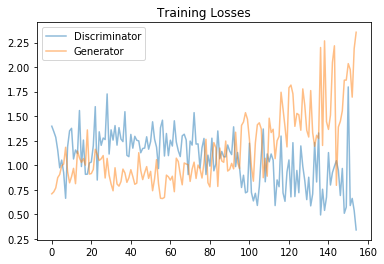

In [27]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [28]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [29]:
# Load samples from generator, taken while training
with open('train_samples_200_epochs.pkl', 'rb') as f:
    samples = pkl.load(f)

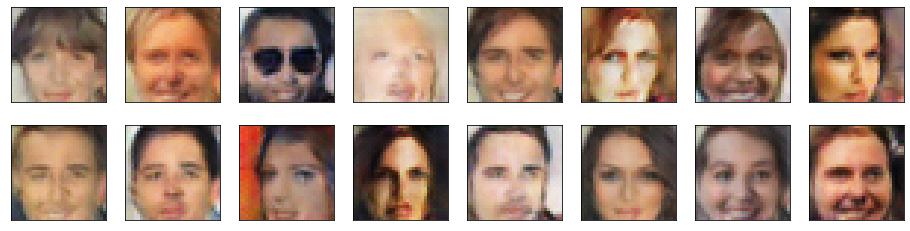

In [30]:
_ = view_samples(1, samples)

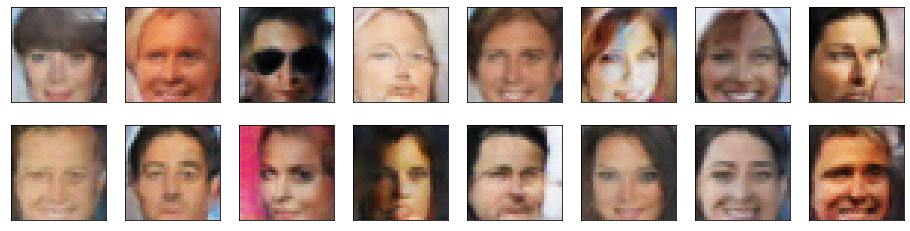

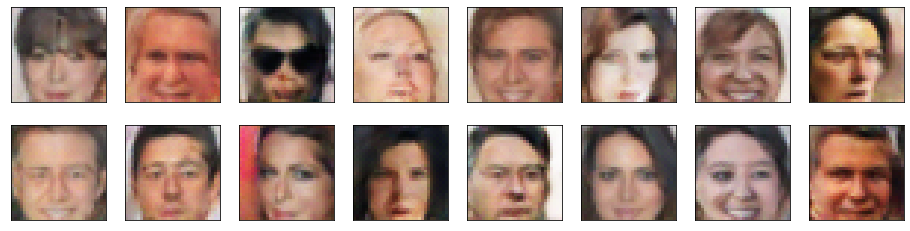

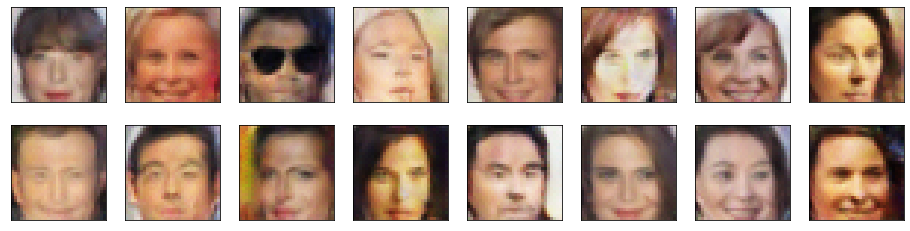

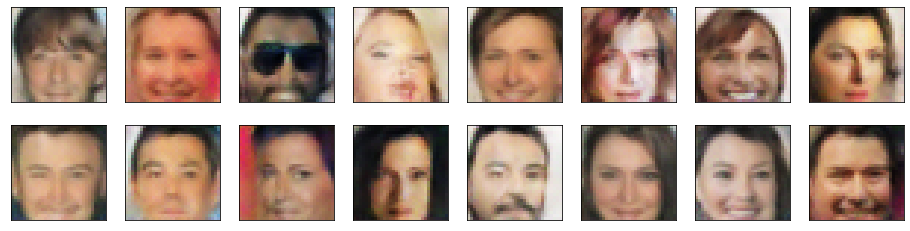

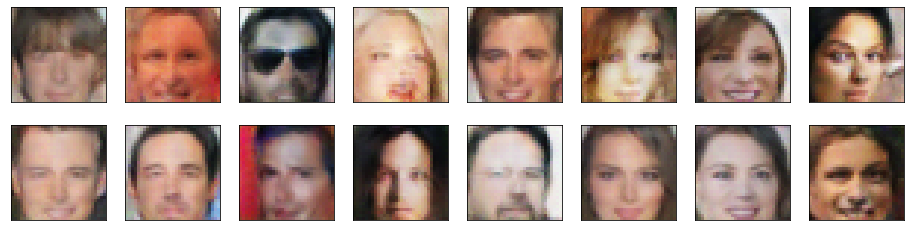

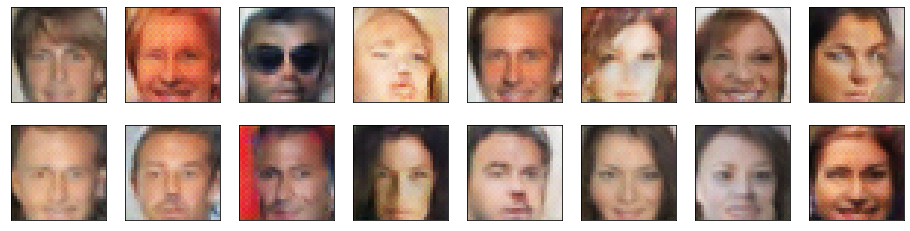

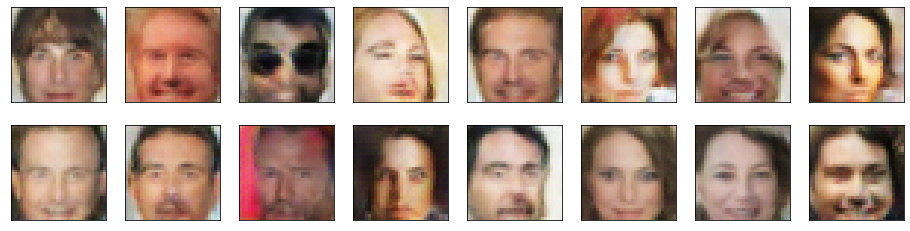

In [31]:
# view result in a loop
for i in range(3, 10):
    _ = view_samples(i, samples)